In this assignment, we will develop a ML model for cybersecurity intrusion detection. Please
visit the website: https://www.unb.ca/cic/datasets/ids-2017.html and look around to see the problem
space and the evaluation datasets to be used for ML model development.
This dataset is collected by cyber experts during experimentation that was carried on for 5
days long. The description of the experiments also inform the experimental ground truth.
(Optional: GeneratedLabelledFlows.zip, note that it is already pre-processed by someone)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error

## 1. [10 pts] Download the labeled dataset, if you like use a dummy email address for registration. There must be 8 data files, each representing a particular cyber-attack type and it's day, and it's collected pcap data.

In [2]:
# load in all the files
folder = 'TrafficLabelling '
files = ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
        'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 
        'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
        'Tuesday-WorkingHours.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv']
dfs = []
for name in files:
    dfs.append(pd.read_csv(folder+'/' +name))
dfs

/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,1,3,6,84) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


[                                        Flow ID       Source IP   Source Port  \
 0       192.168.10.5-104.16.207.165-54865-443-6  104.16.207.165           443   
 1         192.168.10.5-104.16.28.216-55054-80-6   104.16.28.216            80   
 2         192.168.10.5-104.16.28.216-55055-80-6   104.16.28.216            80   
 3       192.168.10.16-104.17.241.25-46236-443-6   104.17.241.25           443   
 4       192.168.10.5-104.19.196.102-54863-443-6  104.19.196.102           443   
 ...                                         ...             ...           ...   
 225740     192.168.10.15-72.21.91.29-61374-80-6     72.21.91.29            80   
 225741     192.168.10.15-72.21.91.29-61378-80-6     72.21.91.29            80   
 225742     192.168.10.15-72.21.91.29-61375-80-6     72.21.91.29            80   
 225743    192.168.10.15-8.41.222.187-61323-80-6    8.41.222.187            80   
 225744      192.168.10.15-8.43.72.21-61326-80-6      8.43.72.21            80   
 
         Desti

## 2. [10 pts] Pick one of the data files, call it Dataset 1, and examine its features. Make sure it has more than one class value for its label.

In [3]:
dataset1 = dfs[0]
dataset1 = dataset1.rename(columns=lambda x: x.strip())
dataset1['Label'].unique()
## has 2 labels, benign and DDoS

array(['BENIGN', 'DDoS'], dtype=object)

In [4]:
dataset1

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,192.168.10.15-72.21.91.29-61374-80-6,72.21.91.29,80,192.168.10.15,61374,6,7/7/2017 5:02,61,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225741,192.168.10.15-72.21.91.29-61378-80-6,72.21.91.29,80,192.168.10.15,61378,6,7/7/2017 5:02,72,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225742,192.168.10.15-72.21.91.29-61375-80-6,72.21.91.29,80,192.168.10.15,61375,6,7/7/2017 5:02,75,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225743,192.168.10.15-8.41.222.187-61323-80-6,8.41.222.187,80,192.168.10.15,61323,6,7/7/2017 5:02,48,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## 3. [10 pts] For the Dataset 1, pick a machine learning methodology and justify your choice.

I will be using a LSTM for this dataset because of 3 main reasons. First, this is time series data and I believe that a time series model will be useful. Second, LSTM's can determine classification problems. Third, neural networks are state of the art and there is enough data for a neural network.

## 4. [10 pts] Process the class feature/category as binary classes for supervised learning, assign BENIGN to value 0 and the rest to value 1. Check its balance for the Dataset 1.

In [5]:
##label encode dependant variable
le = LabelEncoder()
dataset1['Label'] = le.fit_transform(dataset1['Label'])
dataset1['Label'].value_counts()

1    128027
0     97718
Name: Label, dtype: int64

In [6]:
#print label counts and ratio
ben = dataset1[dataset1['Label'] == 0]
dd = dataset1[dataset1['Label'] == 1]
print('BENIGN:', len(ben), '\nDDoS:', len(dd), '\nRatio BENIGN:', len(ben)/(len(ben) + len(dd)))

BENIGN: 97718 
DDoS: 128027 
Ratio BENIGN: 0.4328689450486168


## 5. [10 pts] Explore Dataset 1 features with respect to the class. (Hint: features Source Port and Destination Port are very useful, research and find out important networking port numbers and one-hot-encode them. Unimportant port numbers or source port numbers can be assigned to a feature called 'other ports')

In [7]:
#convert strings to ints, can't label encode but can remove str characters
dataset1['Flow ID'] = dataset1['Flow ID'].apply(lambda x: int(x.replace('.', '').replace('-', '')))
dataset1['Source IP'] = dataset1['Source IP'].apply(lambda x: int(x.replace('.', '')))
dataset1['Destination IP'] = dataset1['Destination IP'].apply(lambda x: int(x.replace('.', '')))
dataset1['Timestamp'] = dataset1['Timestamp'].apply(lambda x: int(datetime.strptime(x, '%m/%d/%Y %H:%M').timestamp()))

In [8]:
#at least for dataset 1 all these are useless
print('BWD PSH', dataset1['Bwd PSH Flags'].value_counts())
print('FWD URG', dataset1['Fwd URG Flags'].value_counts())
print('BWD URG', dataset1['Bwd URG Flags'].value_counts())
print('FWD AVG', dataset1['Fwd Avg Bytes/Bulk'].value_counts())
print('FWD AVG Pack', dataset1['Fwd Avg Packets/Bulk'].value_counts())
print('FWD AVG Rate', dataset1['Fwd Avg Bulk Rate'].value_counts())
print('BWD AVG', dataset1['Bwd Avg Bytes/Bulk'].value_counts())
print('BWD AVG Pack', dataset1['Bwd Avg Packets/Bulk'].value_counts())
print('BWD AVG Rate', dataset1['Bwd Avg Bulk Rate'].value_counts())
dataset1 = dataset1.drop(columns=['Bwd PSH Flags','Fwd URG Flags','Bwd URG Flags','Fwd Avg Bytes/Bulk','Fwd Avg Packets/Bulk',
                                 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk','Bwd Avg Packets/Bulk','Bwd Avg Bulk Rate'])

BWD PSH 0    225745
Name: Bwd PSH Flags, dtype: int64
FWD URG 0    225745
Name: Fwd URG Flags, dtype: int64
BWD URG 0    225745
Name: Bwd URG Flags, dtype: int64
FWD AVG 0    225745
Name: Fwd Avg Bytes/Bulk, dtype: int64
FWD AVG Pack 0    225745
Name: Fwd Avg Packets/Bulk, dtype: int64
FWD AVG Rate 0    225745
Name: Fwd Avg Bulk Rate, dtype: int64
BWD AVG 0    225745
Name: Bwd Avg Bytes/Bulk, dtype: int64
BWD AVG Pack 0    225745
Name: Bwd Avg Packets/Bulk, dtype: int64
BWD AVG Rate 0    225745
Name: Bwd Avg Bulk Rate, dtype: int64


In [9]:
for col in dataset1.columns:
    small = dataset1[[col, 'Label']]
    print(col)
    print(small.corr())
    print('\n')

Flow ID
       Label
Label    1.0


Source IP
           Source IP     Label
Source IP   1.000000 -0.166923
Label      -0.166923  1.000000


Source Port
             Source Port     Label
Source Port     1.000000  0.388721
Label           0.388721  1.000000


Destination IP
                Destination IP     Label
Destination IP        1.000000 -0.094546
Label                -0.094546  1.000000


Destination Port
                  Destination Port     Label
Destination Port          1.000000 -0.509798
Label                    -0.509798  1.000000


Protocol
          Protocol     Label
Protocol  1.000000 -0.471904
Label    -0.471904  1.000000


Timestamp
           Timestamp     Label
Timestamp   1.000000 -0.147953
Label      -0.147953  1.000000


Flow Duration
               Flow Duration     Label
Flow Duration       1.000000  0.025923
Label               0.025923  1.000000


Total Fwd Packets
                   Total Fwd Packets    Label
Total Fwd Packets            1.00000 -0.02987


In [10]:
sports = dataset1['Source Port']
dports = dataset1['Destination Port']
print('s\n', sports.value_counts(), '\nd\n', dports.value_counts())

s
 80       33528
443       6419
123        362
137        274
22         156
         ...  
5889         1
8800         1
10849        1
28092        1
2047         1
Name: Source Port, Length: 50697, dtype: int64 
d
 80       136951
53        31950
443       13485
8080        510
123         362
          ...  
33446         1
60075         1
15025         1
27323         1
10235         1
Name: Destination Port, Length: 23950, dtype: int64


20

File Transfer Protocol (FTP) Data Transfer

21

File Transfer Protocol (FTP) Command Control

22

Secure Shell (SSH)

23

Telnet - Remote login service, unencrypted text messages

25

Simple Mail Transfer Protocol (SMTP) E-mail Routing

53

Domain Name System (DNS) service

80

Hypertext Transfer Protocol (HTTP) used in World Wide Web

110

Post Office Protocol (POP3) used by e-mail clients to retrieve e-mail from a server

119

Network News Transfer Protocol (NNTP)

123

Network Time Protocol (NTP)

143

Internet Message Access Protocol (IMAP) Management of Digital Mail

161

Simple Network Management Protocol (SNMP)

194

Internet Relay Chat (IRC)

443

HTTP Secure (HTTPS) HTTP over TLS/SSL

In [11]:
ports = ['20', '21', '22', '23', '25', '53', '80','110','119','123', '137', '143','161','194','443', '3389', '8080']
for port in ports:
    scol = 's' + port
    dcol = 'd' + port
    dataset1[scol] = dataset1['Source Port'].apply(lambda x: 1 if str(x)==port else 0)
    dataset1[dcol] = dataset1['Destination Port'].apply(lambda x: 1 if str(x)==port else 0)
dataset1['sother']= dataset1['Source Port'].apply(lambda x: 1 if not str(x) in ports else 0)
dataset1['dother']= dataset1['Destination Port'].apply(lambda x: 1 if not str(x) in ports else 0)
dataset1

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,s194,d194,s443,d443,s3389,d3389,s8080,d8080,sother,dother
0,19216810510416207165548654436,10416207165,443,192168105,54865,6,1499412600,3,2,0,...,0,0,1,0,0,0,0,0,0,1
1,192168105104162821655054806,1041628216,80,192168105,55054,6,1499412600,109,1,1,...,0,0,0,0,0,0,0,0,0,1
2,192168105104162821655055806,1041628216,80,192168105,55055,6,1499412600,52,1,1,...,0,0,0,0,0,0,0,0,0,1
3,19216810161041724125462364436,1041724125,443,1921681016,46236,6,1499412600,34,1,1,...,0,0,1,0,0,0,0,0,0,1
4,19216810510419196102548634436,10419196102,443,192168105,54863,6,1499412600,3,2,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,19216810157221912961374806,72219129,80,1921681015,61374,6,1499418120,61,1,1,...,0,0,0,0,0,0,0,0,0,1
225741,19216810157221912961378806,72219129,80,1921681015,61378,6,1499418120,72,1,1,...,0,0,0,0,0,0,0,0,0,1
225742,19216810157221912961375806,72219129,80,1921681015,61375,6,1499418120,75,1,1,...,0,0,0,0,0,0,0,0,0,1
225743,192168101584122218761323806,841222187,80,1921681015,61323,6,1499418120,48,2,0,...,0,0,0,0,0,0,0,0,0,1


## 6. [10 pts] Display some histograms and anything you deem fit to pick independent Dataset 1 features. (Hint: source/destination bytes, packets, ports and the duration features)

Source Port


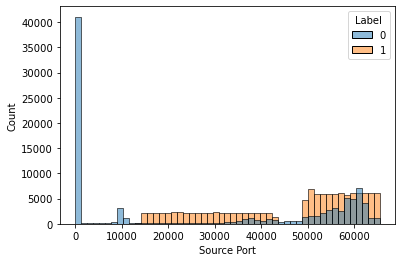

Destination Port


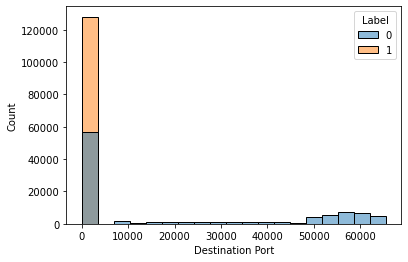

Protocol


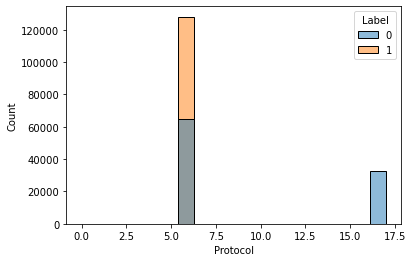

Timestamp


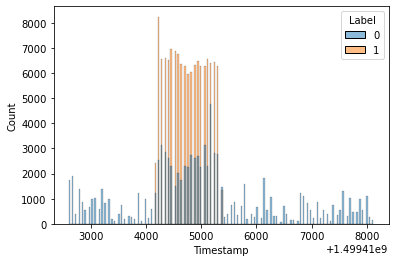

Bwd Packet Length Max


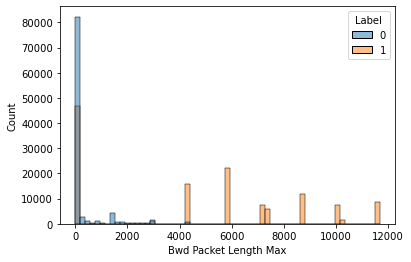

Bwd Packet Length Mean


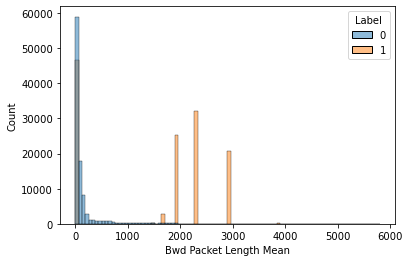

Bwd Packet Length Std


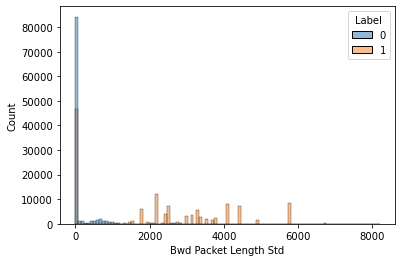

Fwd PSH Flags


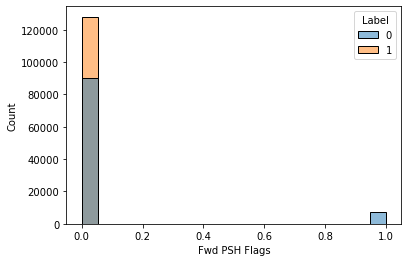

Max Packet Length


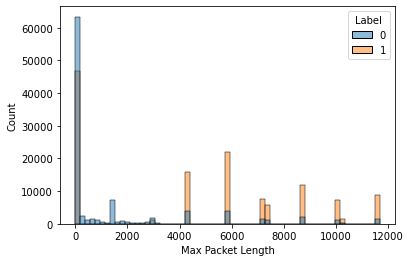

Packet Length Mean


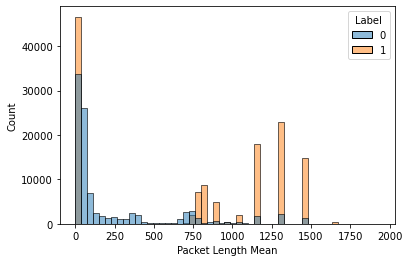

Packet Length Std


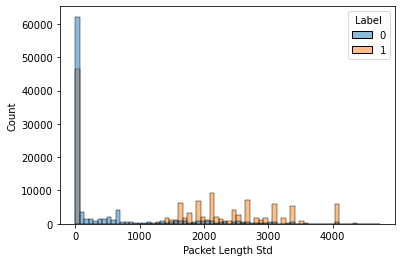

Packet Length Variance


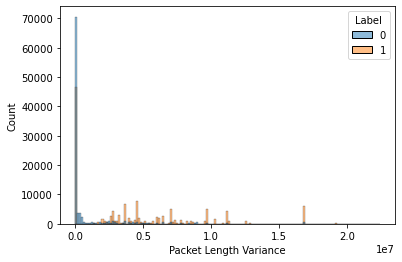

FIN Flag Count


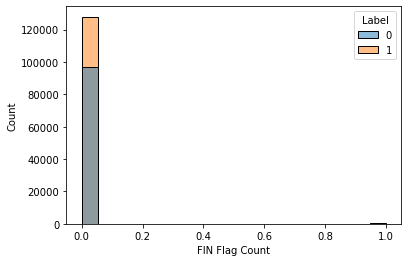

SYN Flag Count


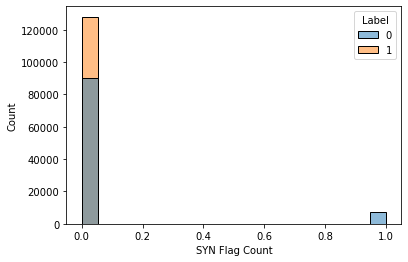

RST Flag Count


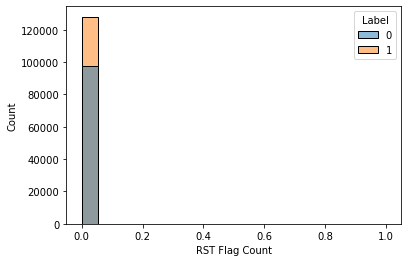

PSH Flag Count


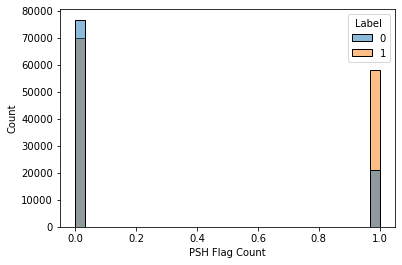

ACK Flag Count


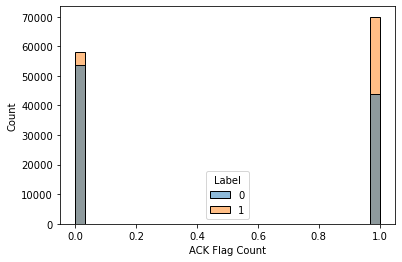

URG Flag Count


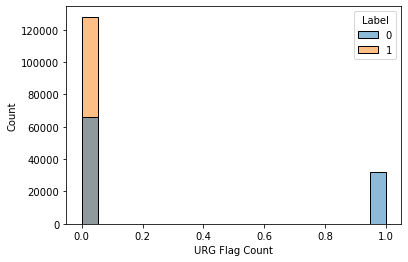

CWE Flag Count


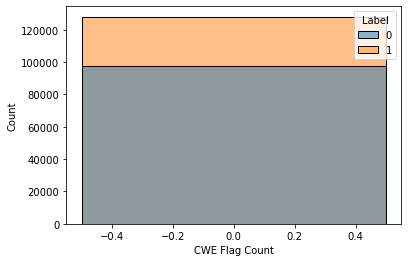

ECE Flag Count


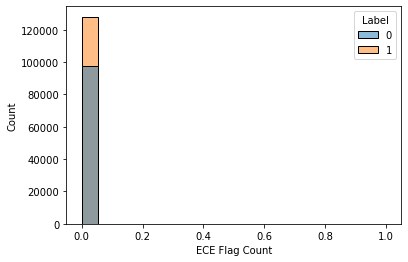

Down/Up Ratio


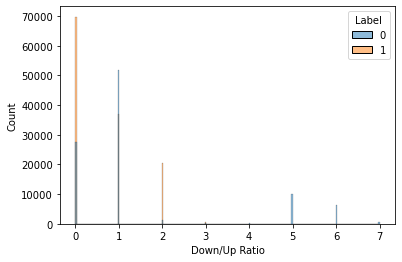

Average Packet Size


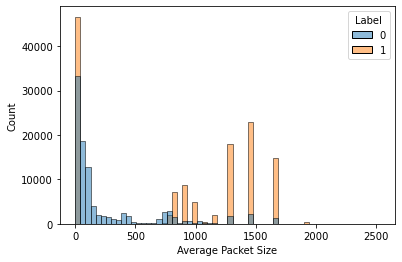

Avg Bwd Segment Size


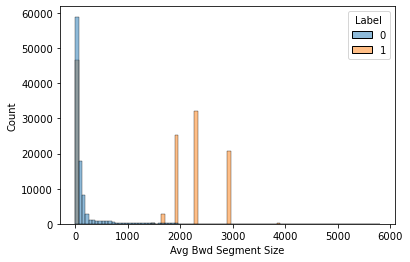

Init_Win_bytes_forward


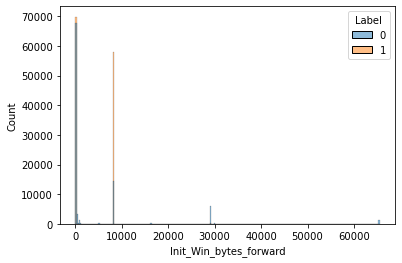

min_seg_size_forward


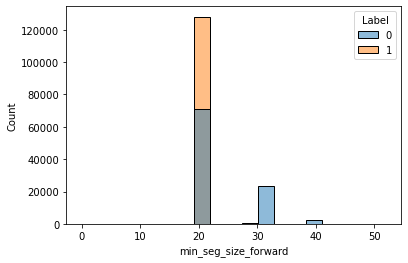

Active Std


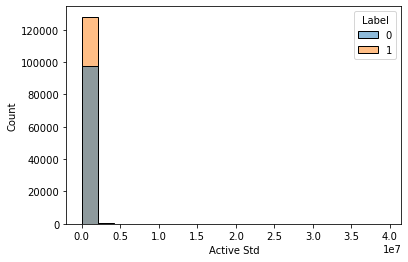

Idle Mean


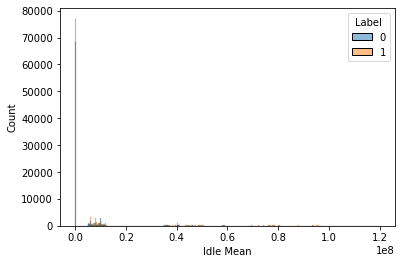

Idle Std


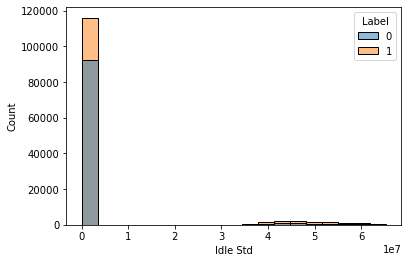

Idle Max


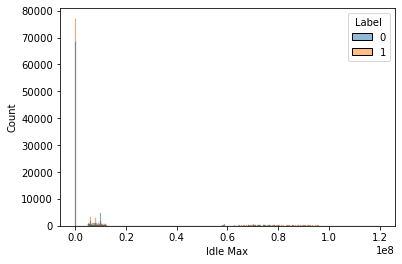

Idle Min


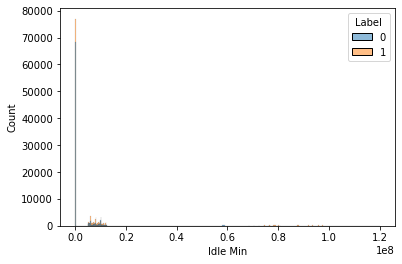

Label


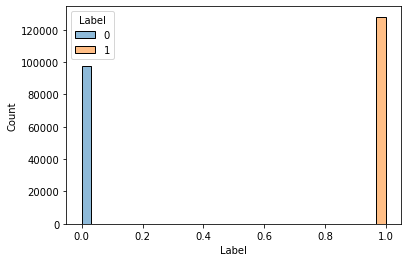

s20


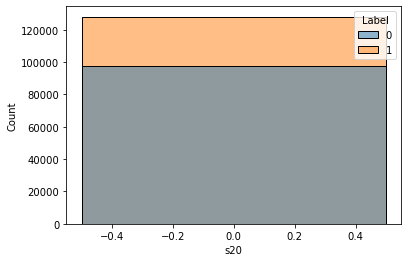

d20


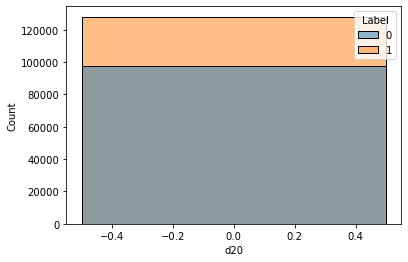

s21


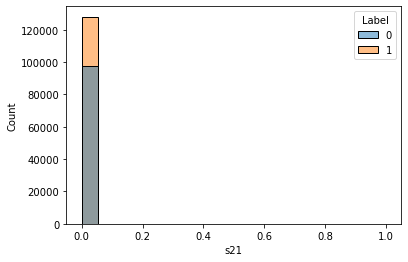

d21


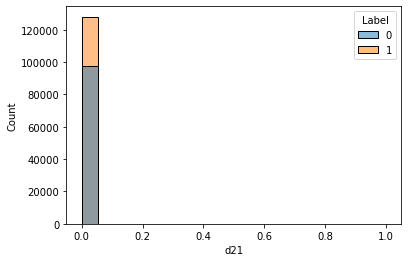

s22


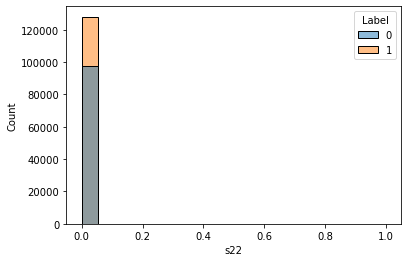

d22


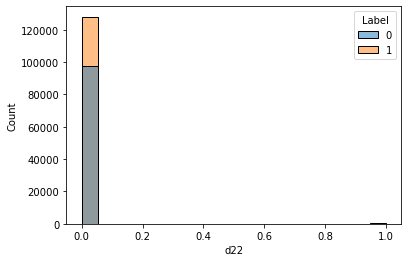

s23


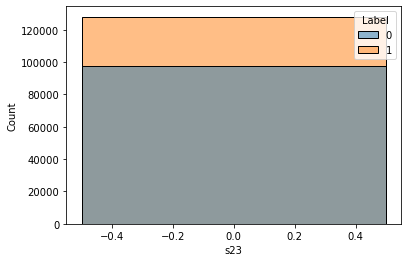

d23


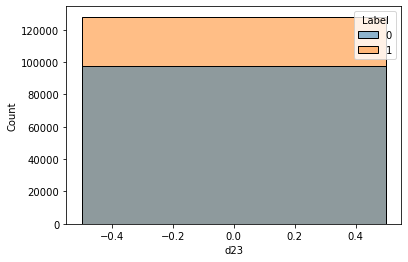

s25


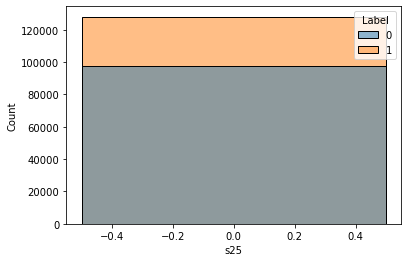

d25


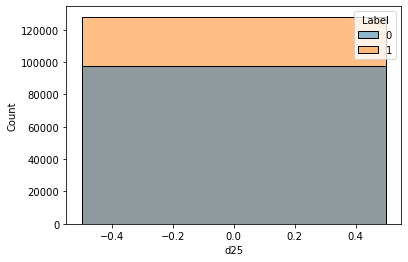

s53


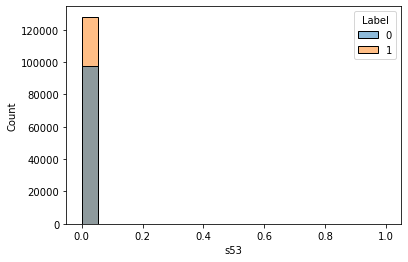

d53


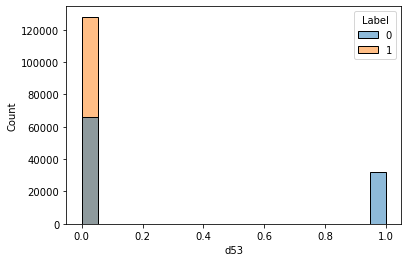

s80


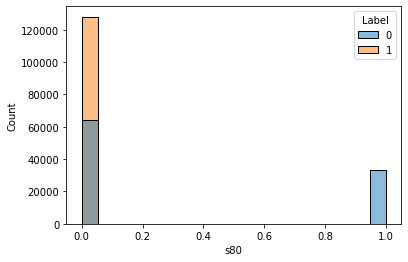

d80


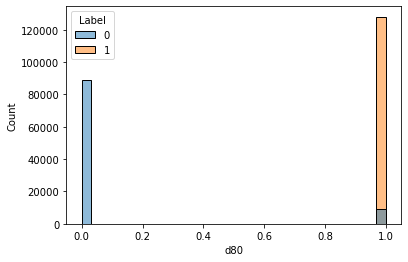

s110


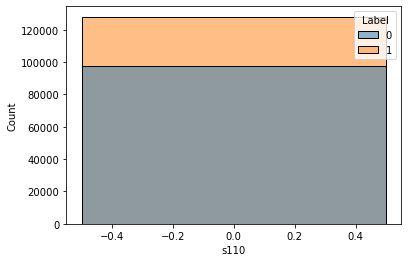

d110


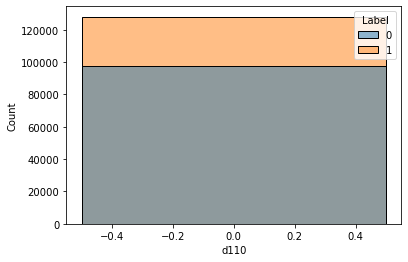

s119


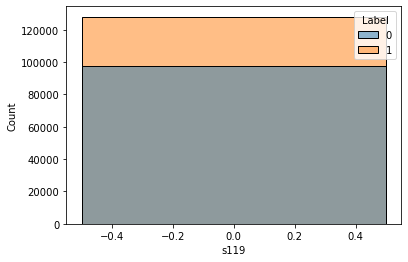

d119


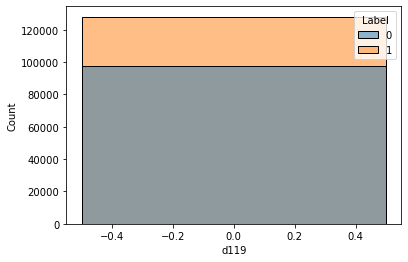

s123


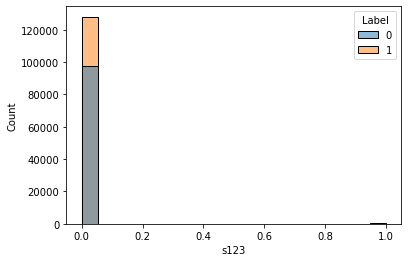

d123


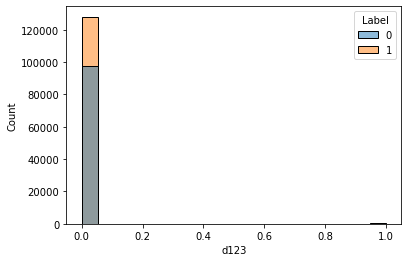

s137


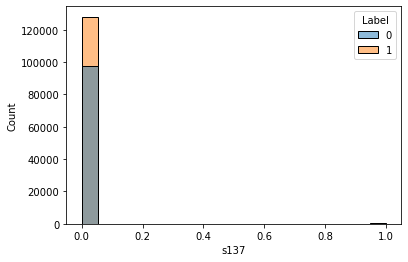

d137


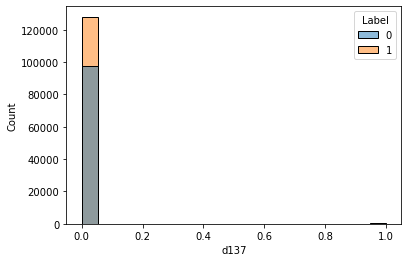

s143


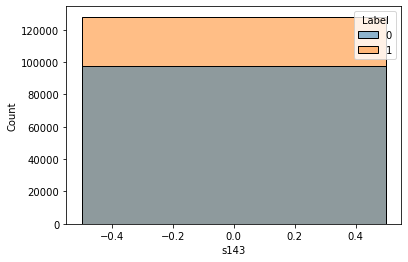

d143


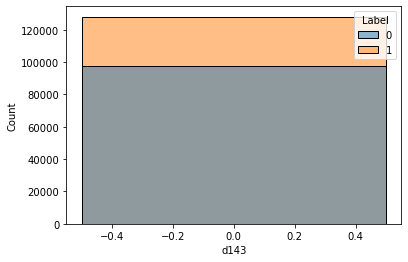

s161


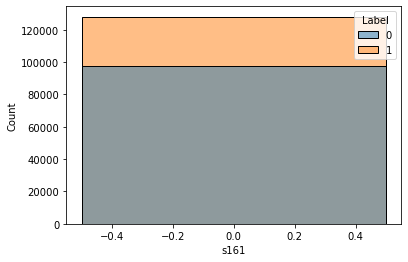

d161


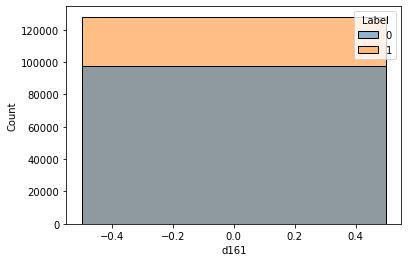

s194


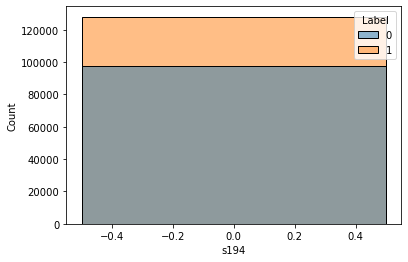

d194


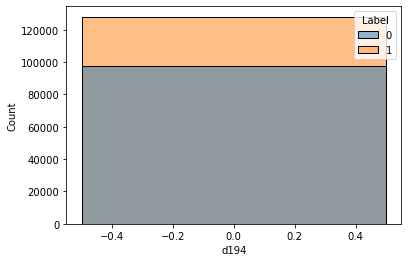

s443


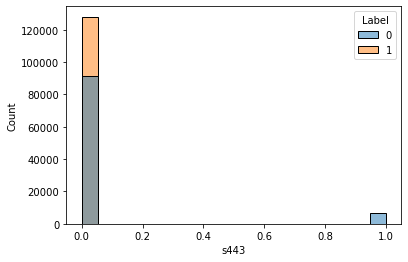

d443


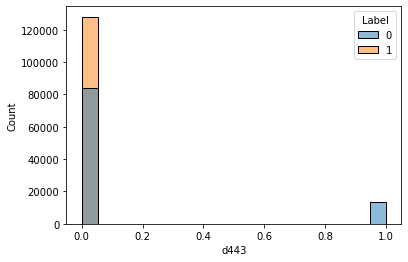

s3389


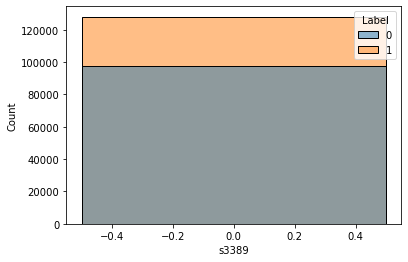

d3389


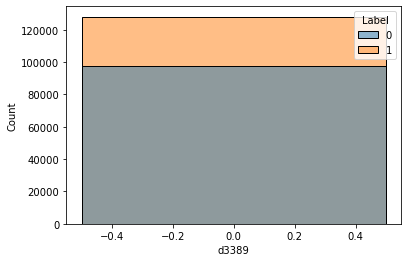

s8080


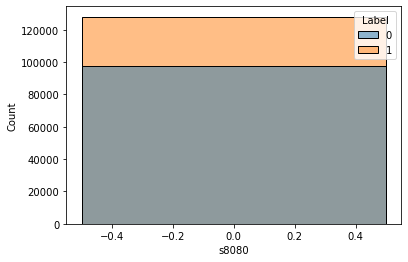

d8080


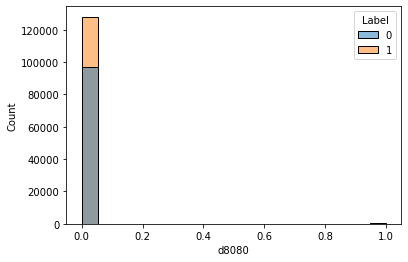

sother


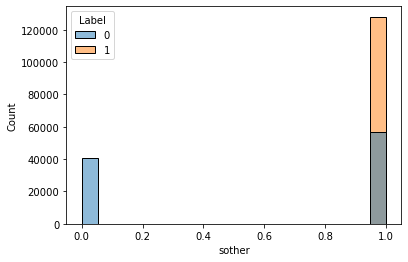

dother


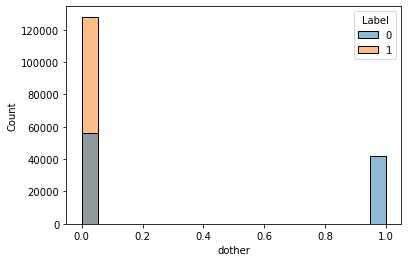

In [12]:
cols = dataset1.columns
##these cols just take too long
problems=['Flow ID', 'Flow Bytes/s', 'Source IP','Flow IAT Std','Bwd IAT Max', 'Fwd Header Length', 'Fwd IAT Max',
          'Flow IAT Max','Flow IAT Mean', 'Total Fwd Packets','Bwd IAT Std', 'Fwd IAT Std','Bwd IAT Mean', 'Fwd IAT Mean',
          'Bwd IAT Total', 'Fwd IAT Total','Bwd Packet Length Min', 'Destination IP', 'Fwd Packet Length Std',
          'Fwd Packet Length Mean','Fwd Packet Length Min','Flow Duration', 'Fwd Packet Length Max', 
          'Total Backward Packets', 'Active Mean', 'Active Max', 'Active Min', 'Subflow Fwd Bytes',
          'Flow Packets/s', 'Flow IAT Min', 'Bwd Packets/s', 'Fwd IAT Min', 'Bwd IAT Min', 'Fwd Packets/s',
          'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Bwd Header Length', 'Min Packet Length', 
          'Avg Fwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Bwd Packets', 
          'Subflow Bwd Bytes', 'Init_Win_bytes_backward', 'act_data_pkt_fwd']
for col in cols:
    if not col in problems:
        print(col)
        sea.histplot(data=dataset1, x=col, hue="Label")
        plt.show()

## 7. [10 pts] Attempt a few classifier models and report their 10-fold CV performance.

In [13]:
dataset1 = dataset1.drop(columns=problems)
dataset1 = dataset1.drop(columns='Timestamp')
dataset1 = dataset1.dropna()
y = dataset1['Label'].to_numpy()
X = dataset1.drop(columns=['Label']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
##I am not going to 10 cross the lstm because it takes too much time
model = Sequential()
model.add(LSTM(4, input_shape=(1, 65)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
model.fit(trainX, y_train, epochs=25, batch_size=16, verbose=2)
LSTMpredict = model.predict(testX).round()
print('LSTM \nAcc:', accuracy_score(y_test, LSTMpredict), '\nf1:', f1_score(y_test, LSTMpredict, average='weighted'))
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
    clf.fit(X_train_fold, y_train_fold)
    SGDpredict = clf.predict(X_test_fold)
    print('SGD \nAcc:', accuracy_score(y_test_fold, SGDpredict), '\nf1:', f1_score(y_test_fold, SGDpredict, average='weighted'))

Epoch 1/25
10582/10582 - 14s - loss: 0.2137
Epoch 2/25
10582/10582 - 12s - loss: 0.2209
Epoch 3/25
10582/10582 - 12s - loss: 0.2181
Epoch 4/25
10582/10582 - 12s - loss: 0.2172
Epoch 5/25
10582/10582 - 12s - loss: 0.2183
Epoch 6/25
10582/10582 - 12s - loss: 0.2177
Epoch 7/25
10582/10582 - 16s - loss: 0.2235
Epoch 8/25
10582/10582 - 13s - loss: 0.2186
Epoch 9/25
10582/10582 - 12s - loss: 0.1927
Epoch 10/25
10582/10582 - 12s - loss: 0.1952
Epoch 11/25
10582/10582 - 12s - loss: 0.1897
Epoch 12/25
10582/10582 - 12s - loss: 0.2109
Epoch 13/25
10582/10582 - 12s - loss: 0.2224
Epoch 14/25
10582/10582 - 12s - loss: 0.2219
Epoch 15/25
10582/10582 - 12s - loss: 0.2008
Epoch 16/25
10582/10582 - 12s - loss: 0.1814
Epoch 17/25
10582/10582 - 12s - loss: 0.2113
Epoch 18/25
10582/10582 - 12s - loss: 0.2229
Epoch 19/25
10582/10582 - 13s - loss: 0.2227
Epoch 20/25
10582/10582 - 12s - loss: 0.2223
Epoch 21/25
10582/10582 - 12s - loss: 0.2223
Epoch 22/25
10582/10582 - 12s - loss: 0.2223
Epoch 23/25
10582/1

/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD 
Acc: 0.7286043352430454 
f1: 0.7214593392053483


/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD 
Acc: 0.7795759258165496 
f1: 0.7776172514171613


/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD 
Acc: 0.7557143700903668 
f1: 0.7520870167732494


/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD 
Acc: 0.7776859016006142 
f1: 0.7748488385813102


/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD 
Acc: 0.804264367137204 
f1: 0.8032756897608676


/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD 
Acc: 0.6175063493001004 
f1: 0.6111082629160783


/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD 
Acc: 0.7159647982989782 
f1: 0.7073350696128362


/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD 
Acc: 0.7580769003602859 
f1: 0.7541396849640165


/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD 
Acc: 0.777613703484938 
f1: 0.7749148972856601
SGD 
Acc: 0.8053750738334318 
f1: 0.8046166406095628


/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


#### The SGD is much quicker so I will use SGD

## 8. [10 pts] Convert your code to be used for the remaining 7 datasets, i.e. Datasets 2-8.

/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


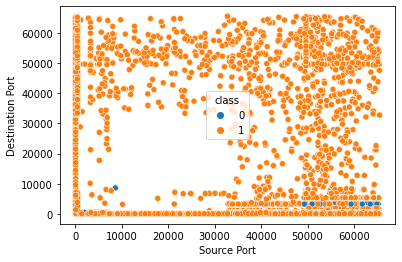

In [15]:
dataset3=dfs[3]
dataset3 = dataset3.rename(columns=lambda x: x.strip())
dataset3['Label'] = le.fit_transform(dataset3['Label'])
ports = ['20', '21', '22', '23', '25', '53', '80','110','119','123', '137', '143','161','194','443', '3389', '8080']
for port in ports:
    scol = 's' + port
    dcol = 'd' + port
    dataset3[scol] = dataset3['Source Port'].apply(lambda x: 1 if str(x)==port else 0)
    dataset3[dcol] = dataset3['Destination Port'].apply(lambda x: 1 if str(x)==port else 0)
dataset3['sother']= dataset3['Source Port'].apply(lambda x: 1 if not str(x) in ports else 0)
dataset3['dother']= dataset3['Destination Port'].apply(lambda x: 1 if not str(x) in ports else 0)
problems=['Flow ID', 'Timestamp', 'Flow Bytes/s', 'Source IP','Flow IAT Std','Bwd IAT Max', 'Fwd Header Length', 'Fwd IAT Max',
          'Flow IAT Max','Flow IAT Mean', 'Total Fwd Packets','Bwd IAT Std', 'Fwd IAT Std','Bwd IAT Mean', 'Fwd IAT Mean',
          'Bwd IAT Total', 'Fwd IAT Total','Bwd Packet Length Min', 'Destination IP', 'Fwd Packet Length Std',
          'Fwd Packet Length Mean','Fwd Packet Length Min','Flow Duration', 'Fwd Packet Length Max', 
          'Total Backward Packets', 'Active Mean', 'Active Max', 'Active Min', 'Subflow Fwd Bytes',
          'Flow Packets/s', 'Flow IAT Min', 'Bwd Packets/s', 'Fwd IAT Min', 'Bwd IAT Min', 'Fwd Packets/s',
          'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Bwd Header Length', 'Min Packet Length', 
          'Avg Fwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Bwd Packets', 
          'Subflow Bwd Bytes', 'Init_Win_bytes_backward', 'act_data_pkt_fwd']
dataset3 = dataset3.drop(columns=problems)
dataset3 = dataset3.dropna()
kmeans = KMeans(n_clusters=2, random_state=0).fit(dataset3)
dataset3['class'] = kmeans.labels_
sea.scatterplot(data=dataset3, x='Source Port', y='Destination Port', hue="class")
plt.show()

In [ ]:
count = 1
for dataset in dfs:
    if count == 1 or count == 4:
        count = count + 1
        continue
    print('\nDataset:', count)
    dataset = dataset.rename(columns=lambda x: x.strip())
    dataset['Label'] = le.fit_transform(dataset['Label'])
    ports = ['20', '21', '22', '23', '25', '53', '80','110','119','123', '137', '143','161','194','443', '3389', '8080']
    for port in ports:
        scol = 's' + port
        dcol = 'd' + port
        dataset[scol] = dataset['Source Port'].apply(lambda x: 1 if str(x)==port else 0)
        dataset[dcol] = dataset['Destination Port'].apply(lambda x: 1 if str(x)==port else 0)
    dataset['sother']= dataset['Source Port'].apply(lambda x: 1 if not str(x) in ports else 0)
    dataset['dother']= dataset['Destination Port'].apply(lambda x: 1 if not str(x) in ports else 0)
    problems=['Flow ID', 'Timestamp', 'Flow Bytes/s', 'Source IP','Flow IAT Std','Bwd IAT Max', 'Fwd Header Length', 'Fwd IAT Max',
          'Flow IAT Max','Flow IAT Mean', 'Total Fwd Packets','Bwd IAT Std', 'Fwd IAT Std','Bwd IAT Mean', 'Fwd IAT Mean',
          'Bwd IAT Total', 'Fwd IAT Total','Bwd Packet Length Min', 'Destination IP', 'Fwd Packet Length Std',
          'Fwd Packet Length Mean','Fwd Packet Length Min','Flow Duration', 'Fwd Packet Length Max', 
          'Total Backward Packets', 'Active Mean', 'Active Max', 'Active Min', 'Subflow Fwd Bytes',
          'Flow Packets/s', 'Flow IAT Min', 'Bwd Packets/s', 'Fwd IAT Min', 'Bwd IAT Min', 'Fwd Packets/s',
          'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Bwd Header Length', 'Min Packet Length', 
          'Avg Fwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Bwd Packets', 
          'Subflow Bwd Bytes', 'Init_Win_bytes_backward', 'act_data_pkt_fwd']
    dataset = dataset.drop(columns=problems)
    dataset = dataset.dropna()
    y1 = dataset['Label'].to_numpy()
    X1 = dataset.drop(columns=['Label']).to_numpy()
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, random_state=42)
    clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=50)
    clf.fit(X_train1, y_train1)
    SGDpredict = clf.predict(X_test1)
    print('\nAcc:', accuracy_score(y_test1, SGDpredict), '\nf1:', f1_score(y_test1, SGDpredict, average='weighted'))
    count = count + 1


Dataset: 2


/opt/anaconda3/envs/virtualEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "



Acc: 0.9405308795397741 
f1: 0.939961496645554

Dataset: 3

Acc: 0.9902217383111037 
f1: 0.9853774640971064

Dataset: 5


## 9. [10 pts] Pick a classifier algorithm and report it's evaluation for the remaining 7 datasets. Note that one dataset has a single class, which might need an unsupervised learning.

I report the accuracy and f1 scores in the output above. Since dfs[3] is the unsupervised, I do it seperatly. At some point, the kernel breaks for one of the datasets, and I do not know why.

## 10.[10 pts] Briefly write up your thoughts about developing a machine learning model where you are not a subject matter expert, such as, developing a cybersecurity intrusion detection pipeline as in this assignment.

I think this assignment shows how important it is to be a subject matter expert. While the accuracy measures come out pretty high, I think this was more luck than anything. I am removing a lot of columns without knowing their real impact on the label. I also am not sure how important time series data is in this scenario. If I was a subject matter expert, I might realize what ports are important, how to encode ip addresses, and what columns can be dropped. 